In [ ]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import re
import string
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from transformers import AutoTokenizer, AutoModel

In [ ]:
pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjectsAI_CodeInjection/Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProjectsAI_CodeInjection/Dataset


In [ ]:
data = pd.read_csv("dataset_capec.csv")
data['text'] = data["text"].str.replace('/',' ')

# BERT

In [ ]:
model_name = 'jackaduma/SecBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_1 = AutoModel.from_pretrained(model_name)
model_2 = AutoModel.from_pretrained(model_name)

In [ ]:
for name, param in model_1.named_parameters():
  # if "5" in name or "4" in name or "3" in name:
    param.requires_grad = False
for name, param in model_2.named_parameters():
  # if "5" in name or "4" in name or "3" in name:
    param.requires_grad = False

X_source = list(X_source)
X_target = list(X_target)
input_texts_source = X_source
input_text_target = X_target

X_train = []
X_test = []

for i , text in enumerate(input_texts_source):

    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([token_ids])

    if (input_tensor.shape[1] > 512):
      input_tensor = input_tensor[:, :512]
    else:
      input_tensor = torch.cat((input_tensor, torch.zeros((1, 512 - input_tensor.shape[1]))), 1)

    X_train.append(input_tensor.squeeze())
    if i%1000==0 :
        print(i/len(X_source))

for j , text in enumerate(input_text_target):

    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([token_ids])

    if (input_tensor.shape[1] > 512):
      input_tensor = input_tensor[:, :512]
    else:
      input_tensor = torch.cat((input_tensor, torch.zeros((1, 512 - input_tensor.shape[1]))), 1)

    X_test.append(input_tensor.squeeze())
    if j%1000==0 :
        print(j/len(X_target))

X_test = torch.stack(X_test)
X_train = torch.stack(X_train)

In [ ]:
X_test.shape, X_train.shape

In [ ]:
y_target = np.where(np.logical_or(y_target == 1, y_target == 3), 0, 1)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# MLP

In [ ]:
X = data["text"]
y = data["label"]

# Tiền xử lý dữ liệu
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rlist =['66 - SQL Injection',
        '000 - Normal',
        '194 - Fake the Source of Data',
        '34 - HTTP Response Splitting',
        '126 - Path Traversal',
        '242 - Code Injection',
        '272 - Protocol Manipulation',
        '310 - Scanning for Vulnerable Software',
        '153 - Input Data Manipulation']
mapping = {l: i for i, l in enumerate(rlist)}
y_train = [mapping[s] for s in y_train]
y_test = [mapping[r] for r in y_test]

In [ ]:
model = MLPClassifier(random_state=1, max_iter=20, verbose=True)
model.fit(X_train, y_train)


Iteration 1, loss = 3.01878409
Iteration 2, loss = 1.52912571
Iteration 3, loss = 1.21612011
Iteration 4, loss = 1.05388640
Iteration 5, loss = 0.96210769
Iteration 6, loss = 0.90350641
Iteration 7, loss = 0.86832107
Iteration 8, loss = 0.83416240
Iteration 9, loss = 0.80991655
Iteration 10, loss = 0.79537632
Iteration 11, loss = 0.77993634
Iteration 12, loss = 0.77712321
Iteration 13, loss = 0.76480435
Iteration 14, loss = 0.75556965
Iteration 15, loss = 0.75353558
Iteration 16, loss = 0.74955310
Iteration 17, loss = 0.74180504
Iteration 18, loss = 0.74308816
Iteration 19, loss = 0.73864400
Iteration 20, loss = 0.73542353


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20, random_state=1, verbose=True)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=rlist, labels= range(10)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 10, does not match size of target_names, 9
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

                                        precision    recall  f1-score   support

                    66 - SQL Injection       0.73      0.76      0.74     49733
                          000 - Normal       0.70      0.78      0.74     45358
         194 - Fake the Source of Data       0.73      0.44      0.55     11188
          34 - HTTP Response Splitting       0.84      0.73      0.78      3730
                  126 - Path Traversal       0.93      0.79      0.86      3534
                  242 - Code Injection       0.99      0.85      0.91      2735
           272 - Protocol Manipulation       0.50      0.00      0.00      1383
310 - Scanning for Vulnerable Software       0.58      0.77      0.66       472
         153 - Input Data Manipulation       0.26      0.10      0.15       227

                             micro avg       0.73      0.73      0.73    118360
                             macro avg       0.63      0.52      0.54    118360
                          weighted avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


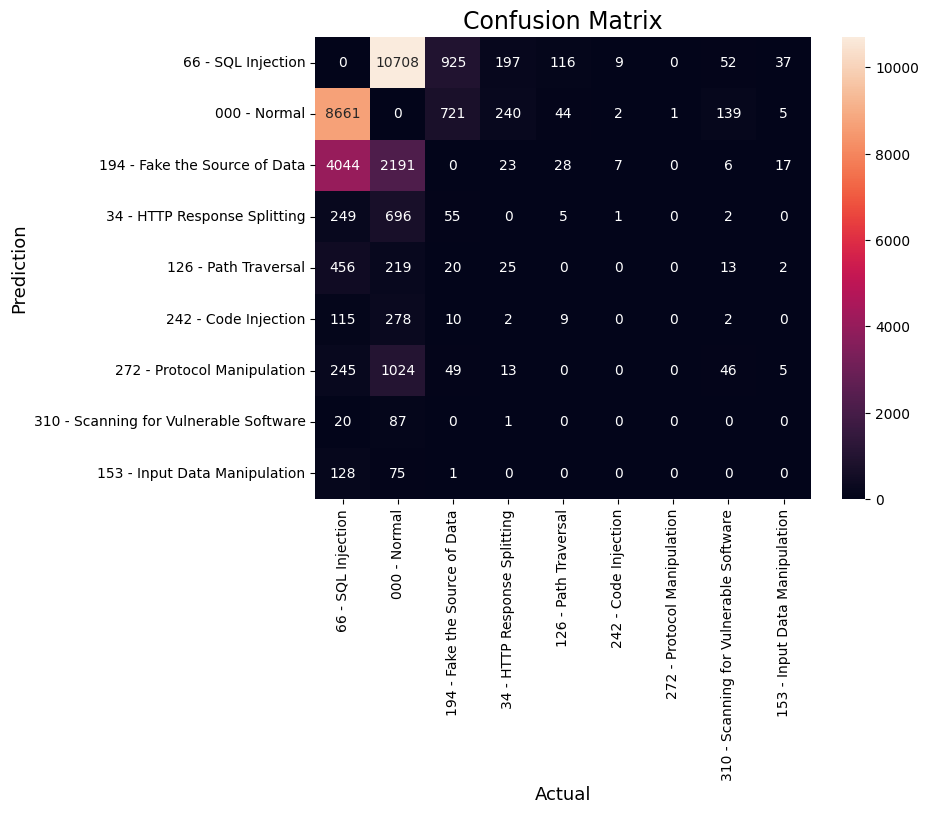

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm,0)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

sns.heatmap(cm,
            annot=True,
            fmt='g', xticklabels=rlist, yticklabels= rlist)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()